#  <center> Emotion recognition And classification of speech signals 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/'My Drive'/Colab\ Notebooks/data

/content/gdrive/My Drive/Colab Notebooks/data


# download dataset

In [ ]:
# import os
# os.environ['KAGGLE_USERNAME'] = "aaabhishekaanand" # username from the json file
# os.environ['KAGGLE_KEY'] = "c3daa8ff7b010f00399d737c8e22ea6b" # key from the json file
# !kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

# #
# #kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

In [ ]:
# os.listdir()

In [ ]:
# !unzip ravdess-emotional-speech-audio.zipA

In [ ]:
# import os
# os.environ['KAGGLE_USERNAME'] = "aaabhishekaanand" # username from the json file
# os.environ['KAGGLE_KEY'] = "c3daa8ff7b010f00399d737c8e22ea6b" # key from the json file
# !kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

# #
# #kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

In [ ]:
# !unzip toronto-emotional-speech-set-tess.zip

In [ ]:
# import os
# os.environ['KAGGLE_USERNAME'] = "aaabhishekaanand" # username from the json file
# os.environ['KAGGLE_KEY'] = "c3daa8ff7b010f00399d737c8e22ea6b" # key from the json file
# !kaggle datasets download -d ejlok1/cremad


In [ ]:
# !unzip cremad.zip

In [ ]:
# import os
# os.environ['KAGGLE_USERNAME'] = "aaabhishekaanand" # username from the json file
# os.environ['KAGGLE_KEY'] = "c3daa8ff7b010f00399d737c8e22ea6b" # key from the json file
# !kaggle datasets download -d barelydedicated/savee-database


In [ ]:
# !unzip savee-database.zip

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
# Paths for data.
# Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
# Crema = "/kaggle/input/cremad/AudioWAV/"
# Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
# Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"




Ravdess = "audio_speech_actors_01-24/"
Crema = "AudioWAV/"
Tess = "tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "ALL/"



##  <center> 1. Ravdess Dataframe <center>
Filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0     calm  audio_speech_actors_01-24/Actor_01/03-01-02-02...
1      sad  audio_speech_actors_01-24/Actor_01/03-01-04-02...
2    angry  audio_speech_actors_01-24/Actor_01/03-01-05-01...
3    angry  audio_speech_actors_01-24/Actor_01/03-01-05-02...
4  neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...

## <center>2. Crema DataFrame</center>

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                          Path
0      sad  AudioWAV/1030_ITS_SAD_XX.wav
1     fear  AudioWAV/1030_ITS_FEA_XX.wav
2    happy  AudioWAV/1030_MTI_HAP_XX.wav
3     fear  AudioWAV/1030_IWW_FEA_XX.wav
4      sad  AudioWAV/1030_MTI_SAD_XX.wav

##  <center> 3. TESS dataset <center>

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0     fear  tess toronto emotional speech set data/TESS To...
1     fear  tess toronto emotional speech set data/TESS To...
2     fear  tess toronto emotional speech set data/TESS To...
3     fear  tess toronto emotional speech set data/TESS To...
4     fear  tess toronto emotional speech set data/TESS To...

##  <center> 4. CREMA-D dataset <center>
File naming convention:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions          Path
0  surprise  ALL/Actor_01
1  surprise  ALL/Actor_02
2  surprise  ALL/Actor_03
3  surprise  ALL/Actor_04
4  surprise  ALL/Actor_05

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0     calm  audio_speech_actors_01-24/Actor_01/03-01-02-02...
1      sad  audio_speech_actors_01-24/Actor_01/03-01-04-02...
2    angry  audio_speech_actors_01-24/Actor_01/03-01-05-01...
3    angry  audio_speech_actors_01-24/Actor_01/03-01-05-02...
4  neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...

In [ ]:
data_path = data_path[:2000]

## Data Visualisation and Exploration

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


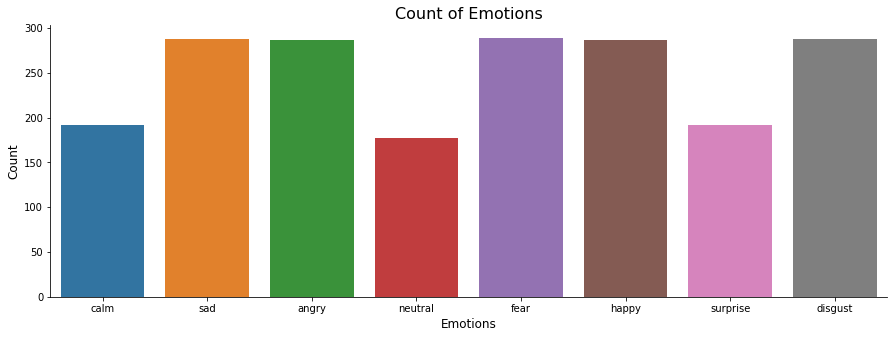

In [ ]:
plt.figure( figsize = (15,5))
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Plotting waveplots and spectograms for audio signals

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

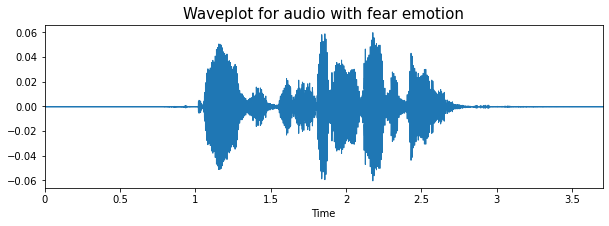

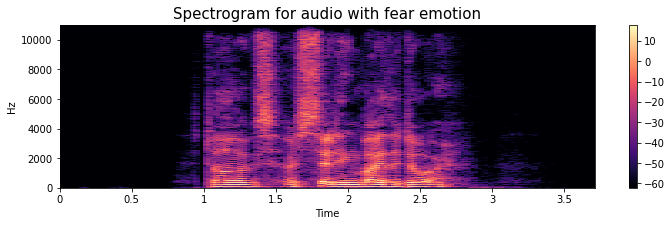

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

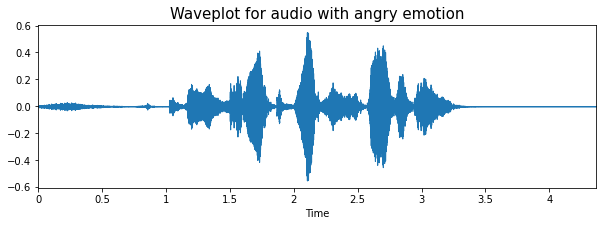

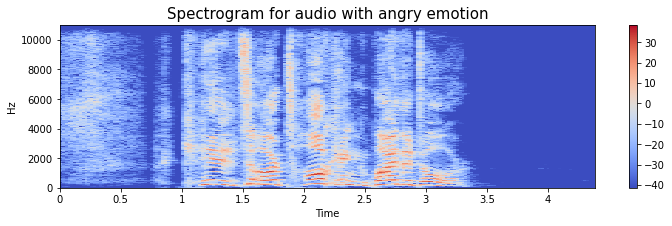

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

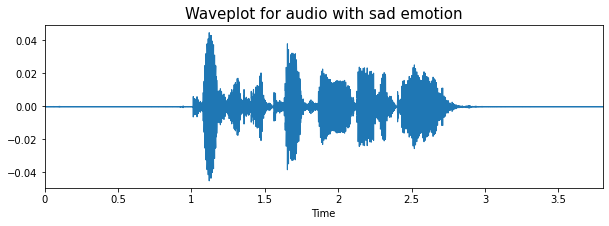

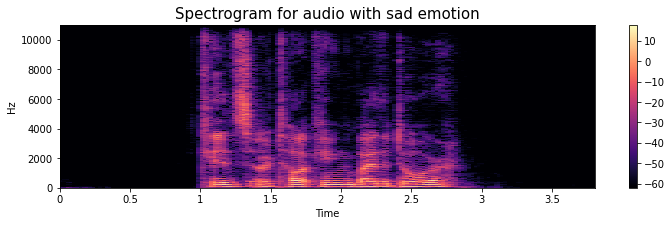

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

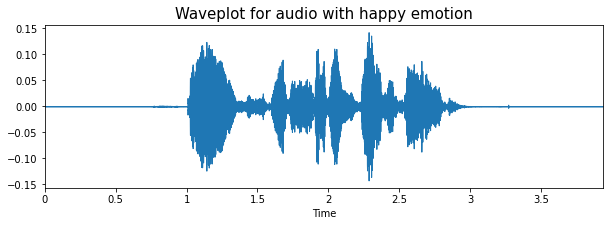

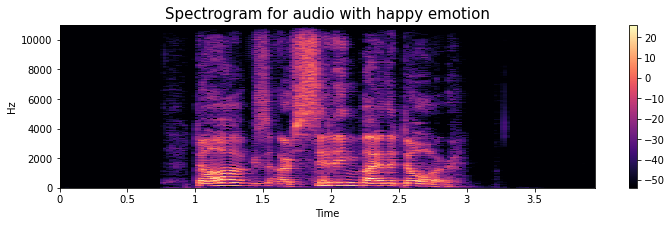

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

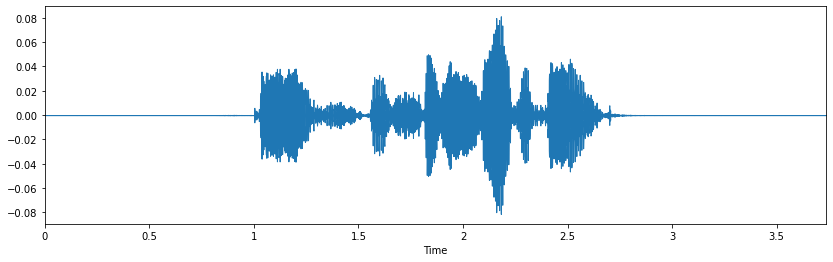

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

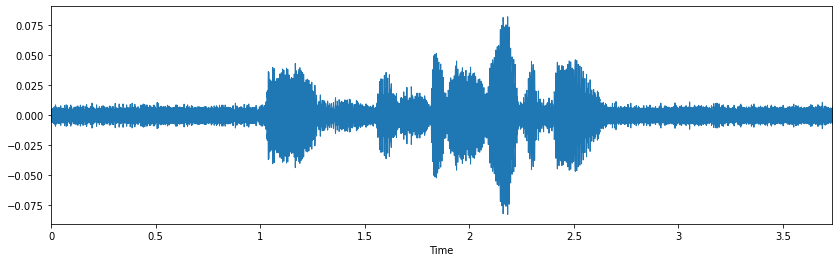

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

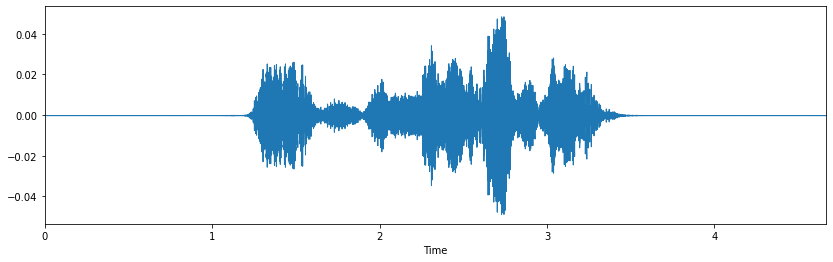

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

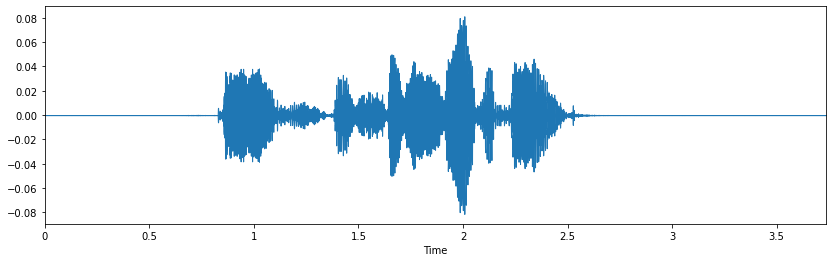

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

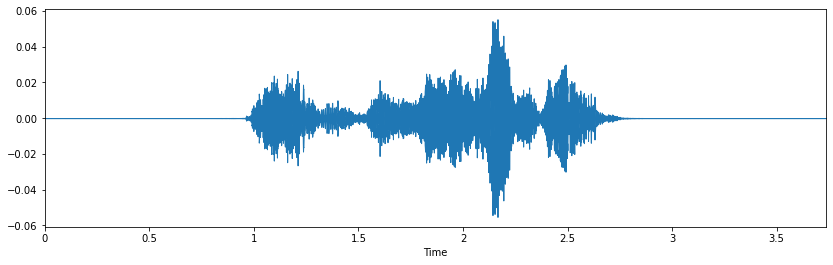

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
# THIS STEP WILL TAKE 1 SEC PER AUDIO FILE

X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.Path.shape

(6000, 6000, (2000,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2  ...       160           161  labels
0  0.185872  0.526278  0.617721  ...  0.000009  5.175063e-07    calm
1  0.217489  0.659893  0.754234  ...  0.000024  1.575595e-05    calm
2  0.159154  0.539747  0.527135  ...  0.000002  9.601939e-08    calm
3  0.195466  0.628032  0.687169  ...  0.000031  2.326331e-06     sad
4  0.268749  0.710959  0.772458  ...  0.000177  1.580464e-04     sad

[5 rows x 163 columns]

# Training start from here

In [ ]:
Features = pd.read_csv("features.csv")

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4500, 162), (4500, 8), (1500, 162), (1500, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4500, 162), (4500, 8), (1500, 162), (1500, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4500, 162, 1), (4500, 8), (1500, 162, 1), (1500, 8))

## Modelling

In [ ]:
# model.add(Layers.Conv2D(filters=64, kernel_size=(3,3),padding="Same",activation="relu" , input_shape = (256,256,3)))
#     model.add(Layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
#     model.add(Layers.BatchNormalization())
#     model.add(Layers.Dropout(0.25))
#     # 2nd Convolutional Layer
#     model.add(Layers.Conv2D(filters=128, kernel_size=(3,3),padding="Same",activation="relu"))
#     model.add(Layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
#     model.add(Layers.BatchNormalization())
#     model.add(Layers.Dropout(0.25))
#     # 3rd Convolutional Layer
#     model.add(Layers.Conv2D(filters=256, kernel_size=(3,3),padding="Same",activation="relu"))
#     model.add(Layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
#     model.add(Layers.BatchNormalization())
#     model.add(Layers.Dropout(0.25))
#     # 4th Convolutional Layer
#     model.add(Layers.Conv2D(filters=256,kernel_size = (3,3),padding="Same",activation="relu"))
#     model.add(Layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
#     model.add(Layers.BatchNormalization())
#     model.add(Layers.Dropout(0.25))
#     # 5th Convolutional Layer
#     model.add(Layers.Conv2D(filters=512,kernel_size = (3,3),padding="Same",activation="relu"))
#     model.add(Layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
#     model.add(Layers.BatchNormalization())
#     model.add(Layers.Dropout(0.25))

#     model.add(Layers.Flatten())

#     # 1st Fully Connected Layer
#     model.add(Layers.Dense(512,activation="relu"))
#     model.add(Layers.Dropout(0.1))
#     model.add(Layers.BatchNormalization())

#     # 2nd Fully Connected Layer
#     model.add(Layers.Dense(512,activation="relu"))
#     model.add(Layers.Dropout(0.1)) 
#     model.add(Layers.BatchNormalization())
#     # Add output layer
#     model.add(Layers.Dense(7,activation="softmax"))

In [ ]:
model=Sequential()
model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))   # try kernel size 3
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))   # try kernel size 3
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(2048,activation="relu"))
model.add(Dropout(0.1)) 
model.add(BatchNormalization())

model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.1)) 
model.add(BatchNormalization())

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 162, 128)          512       
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 81, 128)           0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 81, 128)           512       
_________________________________________________________________
dropout_73 (Dropout)         (None, 81, 128)           0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 81, 256)           98560     
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 41, 256)           0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 41, 256)         

In [ ]:
num_epochs = 50

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=num_epochs   , validation_data=(x_test, y_test),)
                  #callbacks=[rlrp])

Epoch 1/50
71/71 [==============================] - 2s 35ms/step - loss: 2.4974 - accuracy: 0.2131 - val_loss: 2.6779 - val_accuracy: 0.0987
Epoch 2/50
71/71 [==============================] - 2s 29ms/step - loss: 1.9427 - accuracy: 0.2573 - val_loss: 3.3416 - val_accuracy: 0.1653
Epoch 3/50
71/71 [==============================] - 2s 29ms/step - loss: 1.8556 - accuracy: 0.2822 - val_loss: 3.3180 - val_accuracy: 0.1820
Epoch 4/50
71/71 [==============================] - 2s 29ms/step - loss: 1.7983 - accuracy: 0.3087 - val_loss: 2.8937 - val_accuracy: 0.1127
Epoch 5/50
71/71 [==============================] - 2s 29ms/step - loss: 1.7403 - accuracy: 0.3276 - val_loss: 3.3295 - val_accuracy: 0.1360
Epoch 6/50
71/71 [==============================] - 2s 29ms/step - loss: 1.6899 - accuracy: 0.3540 - val_loss: 3.6185 - val_accuracy: 0.1520
Epoch 7/50
71/71 [==============================] - 2s 29ms/step - loss: 1.6638 - accuracy: 0.3673 - val_loss: 3.0351 - val_accuracy: 0.2367
Epoch 8/50
71

47/47 [==============================] - 0s 6ms/step - loss: 1.1202 - accuracy: 0.7107
Accuracy of our model on test data :  71.06666564941406 %


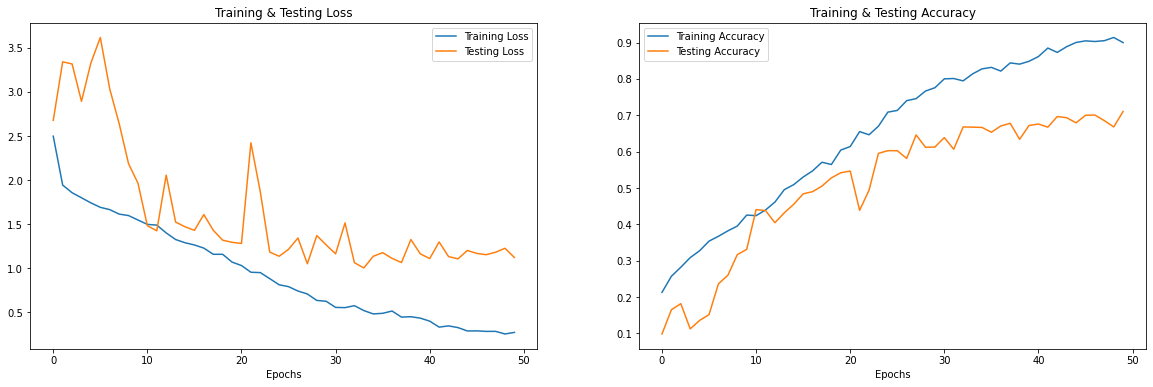

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0             fear           sad
1             calm          calm
2          neutral       neutral
3             fear      surprise
4              sad       neutral
5             calm          calm
6            happy           sad
7            happy       disgust
8            happy         angry
9             fear          fear

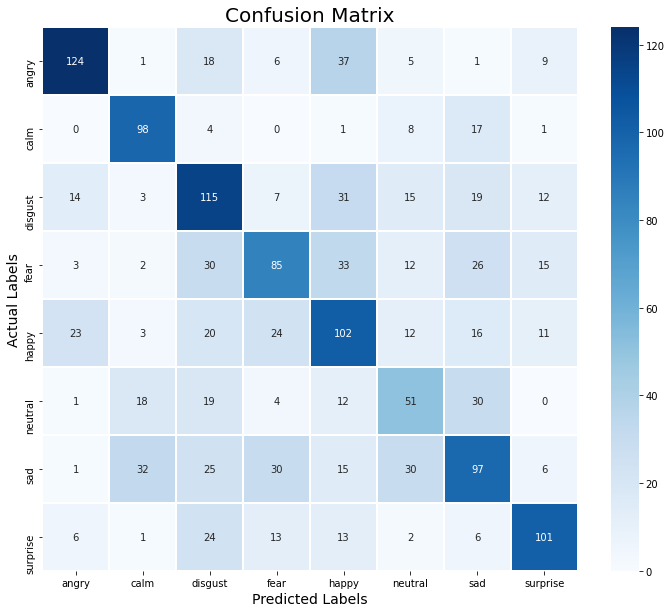

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.72      0.62      0.66       201
        calm       0.62      0.76      0.68       129
     disgust       0.45      0.53      0.49       216
        fear       0.50      0.41      0.45       206
       happy       0.42      0.48      0.45       211
     neutral       0.38      0.38      0.38       135
         sad       0.46      0.41      0.43       236
    surprise       0.65      0.61      0.63       166

    accuracy                           0.52      1500
   macro avg       0.53      0.53      0.52      1500
weighted avg       0.52      0.52      0.52      1500



- The model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data 